# Data pre-processing
 
**Autori:** Erik Matovič a Simon Kokavec   
**Číslo datasetu:** 165  
**Percentuálny podiel:** 50/50

## 0. Importovanie

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as py
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import math
from datetime import datetime, date
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

## 1. Integrácia a čistenie dát

### Zadanie  
Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte. 
- Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie z nasledujúcich podskupín:
    - odstránenie pozorovaní s chýbajúcimi údajmi
    - nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
- Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    - odstránenie vychýlených (odľahlých) pozorovaní
    - nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)
    
### Riešenie


In [39]:
# read labor and profiles dataset
df_labor = pd.read_csv('../../data/labor.csv', sep='\t')
df_profiles = pd.read_csv('../../data/profiles.csv', sep='\t')

In [2]:
def meanNinja(column):
    df_labor[column] = df_labor[column].fillna(df_labor[column].mean())
    
def medianNinja(column):
    df_labor[column] = df_labor[column].fillna(df_labor[column].median())
    
def controlNinja(column):
    print(df_labor[column].loc[df_labor[column].isna(),])
    print(sum(df_labor[column].isna()))
    
def knnNinja(column):
    imputer = KNNImputer(n_neighbors=5)
    copy = df_labor[column].values.reshape(-1,1)
    imputer.fit(copy)
    Xtrans = imputer.transform(copy)
    df_labor[column] = pd.DataFrame(Xtrans)
    
def regressionNinja(column):
    df_labor[column].interpolate(method='linear', inplace=True)

def ratioNinja(columnToFill, corrColumn):
    ratio = df_labor[corrColumn]/df_labor[columnToFill]
    df_labor[columnToFill] = df_labor[columnToFill].fillna(df_labor[corrColumn] * ratio.mean())

#### 1. Dataset profilov

 - **Atribút unnamed(0)** - slúži ako index/riadkovanie, preto celý stĺpec vymazať, nie je potrebný

In [3]:
df_profiles=df_profiles.drop("Unnamed: 0", axis=1)
df_profiles.head()

,name,sex,current_location,blood_group,residence,birthdate,race,ssn,address
0,Elizabeth Johnson,F,"(Decimal('-64.545933'), Decimal('5.817377'))",B-,"319 Bradley Tunnel Suite 246\nBoyerstad, GA 12067","10/30/1938, 00:00:00",White,518-82-6493,"09441 Joyce Route Suite 717\nWest Megan, GA 12969"
1,Scott Holmes,M,"(Decimal('-18.8183775'), Decimal('94.375497'))",A-,"28739 Hoffman Valleys Apt. 636\nMichaelville, ...",1927-06-20,Black,015-03-8632,USNS Miller\nFPO AE 08377
2,William Roth,M,"(Decimal('35.903361'), Decimal('-133.029344'))",B-,"8623 Jordan Canyon Suite 498\nJoshuastad, OH 3...",1965-10-02,Black,898-78-8500,"7747 Nicole Wells\nShannonside, MI 84296"
3,Kimberly Barnes,F,"(Decimal('55.2055095'), Decimal('-121.665483'))",B+,Unit 0522 Box 6156\nDPO AE 24368,1962-02-14,White,478-72-0155,"228 Colleen Extension\nLake Morgan, AL 34806"
4,Sarah Escobar,F,"(Decimal('49.512264'), Decimal('-121.259776'))",AB-,"30306 Molina Junction\nPort Edwardview, OK 72746",02 Oct 1936,Indian,683-31-6335,"08249 Gentry Fall\nLewisshire, NY 20037"


 - **Atribút name** - tento stĺpec je v poriadku, kódovať do numerického tvaru ho nebudeme, potrebný pre spojenie 2 dataframeov, avšak po spojení dataframov sa stane nepotrebný 

In [4]:
df_profiles["name"].head()

0    Elizabeth Johnson
1         Scott Holmes
2         William Roth
3      Kimberly Barnes
4        Sarah Escobar
Name: name, dtype: object

 - **Atribút sex** - tento stĺpec treba pretransformovať z typu *_object_* na numerický typ nasledovne: **1 - žena**, **0 - muž**

In [5]:
df_profiles["sex"].head()

0    F
1    M
2    M
3    F
4    F
Name: sex, dtype: object

In [6]:
df_profiles["sex"].replace({"M": 0, "F": 1}, inplace=True)
df_profiles = df_profiles.astype({'sex': 'category'})
df_profiles["sex"].value_counts()

0    1557
1    1507
Name: sex, dtype: int64

Tento stĺpec sme úspešne transformovali na dátový typ *_category_* a nahradili sme jeho východiskové hodnoty M a F za 0 a 1 ako dokazuje nasledovná bunka:

In [7]:
df_profiles["sex"].head()

0    1
1    0
2    0
3    1
4    1
Name: sex, dtype: category
Categories (2, int64): [0, 1]

# TODO:
- **Atribbút current_location** - tento nebudeme potrebovať pri strojovom učení, nebudeme riešiť kódovanie na numerický tvar, ale jeho vymazanie

In [8]:
df_profiles["current_location"].head()

0       (Decimal('-64.545933'), Decimal('5.817377'))
1     (Decimal('-18.8183775'), Decimal('94.375497'))
2     (Decimal('35.903361'), Decimal('-133.029344'))
3    (Decimal('55.2055095'), Decimal('-121.665483'))
4     (Decimal('49.512264'), Decimal('-121.259776'))
Name: current_location, dtype: object

 - **Atribút blood_group** - hodnoty typu *_object_* kategorizujeme nasledovne: **1(A+), 2(A-), 3(B+), 4(B-), 5(AB+), 6(AB-), 7(O+) a 8(O-)**

In [9]:
df_profiles['blood_group']

0        B-
1        A-
2        B-
3        B+
4       AB-
       ... 
3059    AB+
3060     O+
3061     B+
3062     B-
3063    AB+
Name: blood_group, Length: 3064, dtype: object

In [10]:
df_profiles['blood_group'] = df_profiles['blood_group'].replace({"A+": 1,"A-": 2, "B+": 3, "B-": 4, "AB+": 5, "AB-": 6, "O+": 7, "O-": 8})
df_profiles = df_profiles.astype({'blood_group': 'category'})
df_profiles.blood_group.value_counts()

1    398
3    395
8    394
7    389
5    388
2    377
6    364
4    359
Name: blood_group, dtype: int64

Tento stĺpec sme úspešne transformovali na dátový typ *_category_* a nahradili sme jeho východiskové hodnoty za 1, 2, 3, 4, 5, 6, 7 a 8 ako dokazuje nasledovná bunka:

In [11]:
df_profiles["blood_group"].head()

0    4
1    2
2    4
3    3
4    6
Name: blood_group, dtype: category
Categories (8, int64): [1, 2, 3, 4, 5, 6, 7, 8]

# TODO:
- **Atribút residence** - tento stĺpec je v poriadku, avšak pri strojovom učení nebudeme ho potrebovať, a preto ho odstránime:

In [12]:
df_profiles["residence"].head()

0    319 Bradley Tunnel Suite 246\nBoyerstad, GA 12067
1    28739 Hoffman Valleys Apt. 636\nMichaelville, ...
2    8623 Jordan Canyon Suite 498\nJoshuastad, OH 3...
3                     Unit 0522 Box 6156\nDPO AE 24368
4     30306 Molina Junction\nPort Edwardview, OK 72746
Name: residence, dtype: object

 - **Atribút birthdate** - neobsahuje žiadne chýbajúce hodnoty, avšak je potrebné získať jednotný tvar, pretože súčasný tvar je rôznorodý a zároveň nie je potrebné pre naše účely dátum narodenia pacienta, avšak súčasný vek pacienta môže byť potrebný, a preto nahradíme dátum narodenia za súčasný vek pacienta, ktorý môže byť pre nás viac informatívny

In [13]:
df_profiles['birthdate'] = df_profiles['birthdate'].astype('datetime64[ns]')
df_profiles['birthdate'].head()

0   1938-10-30
1   1927-06-20
2   1965-10-02
3   1962-02-14
4   1936-10-02
Name: birthdate, dtype: datetime64[ns]

In [14]:
df_profiles['birthdate'].isna().value_counts()

False    3064
Name: birthdate, dtype: int64

In [15]:
def age(born):
    """
    Computes current age.
    
    :param born: Date of birth 
    returns: Current age
    """
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))
  
df_profiles['age'] = df_profiles['birthdate'].apply(age)
df_profiles['age'].head()

0    83
1    94
2    56
3    59
4    85
Name: age, dtype: int64

 - **Atribút race** - neobsahuje žiadne chýbajúce hodnoty, hodnoty kategorizujeme nasledovne: **1(White), 2(Black), 3(Asian), 4(Hawaiian), 5(Indian)**

In [16]:
df_profiles.race.value_counts()

White       1565
Black        722
Asian        281
Hawaiian     170
Indian       159
black        102
white         36
blsck         29
Name: race, dtype: int64

Najskôr musíme upraviť hodnoty kde je chyba a ktoré majú na začiatku malé písmeno namiesto veľkého.

In [17]:
df_profiles['race'] = df_profiles['race'].replace({"blsck": "Black", "black": "Black", "white": "White"})
df_profiles.race.value_counts()

White       1601
Black        853
Asian        281
Hawaiian     170
Indian       159
Name: race, dtype: int64

Následne tieto hodnoty kategorizujeme ako sme uviedli vyššie.

In [18]:
df_profiles['race'] = df_profiles['race'].replace({"White": 1,"Black": 2, "Asian": 3, "Hawaiian": 4, "Indian": 5})
df_profiles = df_profiles.astype({'race': 'category'})
df_profiles.race.value_counts()

1    1601
2     853
3     281
4     170
5     159
Name: race, dtype: int64

In [19]:
df_profiles["race"].head()

0    1
1    2
2    2
3    1
4    5
Name: race, dtype: category
Categories (5, int64): [1, 2, 3, 4, 5]

# TODO:
- **Atribút ssn** - tento stĺpec je v poriadku, avšak po spojení dataframeov je nepotrebný pre naše účely, preto ho odstránime

In [20]:
df_profiles["ssn"].head()

0    518-82-6493
1    015-03-8632
2    898-78-8500
3    478-72-0155
4    683-31-6335
Name: ssn, dtype: object

 - **Atribút address** - tento stĺpec je celý v poriadku, avšak nepotrebný pre naše účely, preto ho nebudeme transformovať, ale odstránime ho

In [21]:
df_profiles["address"].head()

0    09441 Joyce Route Suite 717\nWest Megan, GA 12969
1                            USNS Miller\nFPO AE 08377
2             7747 Nicole Wells\nShannonside, MI 84296
3         228 Colleen Extension\nLake Morgan, AL 34806
4              08249 Gentry Fall\nLewisshire, NY 20037
Name: address, dtype: object

#### Dataset laboratórnych výsledkov  

 - **Atribút unnamed(0)** - slúži ako index/riadkovanie, preto celý stĺpec vymazať, nie je potrebný

In [22]:
df_labor=df_labor.drop("Unnamed: 0", axis=1)
df_labor.head()

,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,name,alt,hbver,smoker,erytrocyty,er-cv,indicator,ssn,hematokrit
0,6.77299,5.28153,4.79087,104.22450,7.22472,61.85014,80.77401,married,Kathryn Wagner,2.01576,9.04461,no,7.94417,61.31451,0.0,887-91-9698,5.40103
1,6.35217,5.45245,3.34754,65.03608,7.00407,66.90722,90.01585,widowed,Frank Becker,0.81519,9.09262,no,5.33302,58.00624,0.0,506-37-0250,7.68167
2,5.37162,7.36106,7.10989,63.61518,6.95232,65.33091,74.23784,married,Stephanie Lewis,0.79787,6.18215,no,6.38771,62.73102,1.0,331-52-1241,6.27422
3,4.60987,8.04010,4.97779,30.35294,6.63243,67.33708,34.67995,married,Luis Williams,0.83917,5.22920,no,5.05640,62.60592,1.0,407-22-7513,6.61263
4,5.97408,6.66899,5.58872,97.97181,6.18242,67.48751,89.31030,divoced,Donald Hall,1.20122,4.97805,yes,5.10205,59.32470,1.0,486-30-7935,6.23117


 - **Atribút hemoglobin** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *_priemerom_*

In [4]:
meanNinja("hemoglobin")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [5]:
controlNinja("hemoglobin")

Series([], Name: hemoglobin, dtype: float64)
0


 - **Atribút leukocyty** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *_priemerom_*

In [6]:
ratioNinja("leukocyty","etytr")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [7]:
controlNinja("leukocyty")

Series([], Name: leukocyty, dtype: float64)
0


 - **Atribút etytr** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [8]:
regressionNinja("etytr")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [9]:
controlNinja("etytr")

Series([], Name: etytr, dtype: float64)
0


 - **Atribút weight** - neobsahuje žiadne chýbajúce hodnoty, avšak obsahuje chybné hodnoty(zápornú váhu), ktoré odstránime

In [29]:
df_labor["weight"].loc[df_labor["weight"] < 0]

55     -12.45169
92     -12.09550
99     -32.91044
101     -6.81291
102     -2.97803
          ...   
9705   -16.85572
9739    -5.06729
9899    -3.18994
9918    -4.53449
9947    -4.22324
Name: weight, Length: 203, dtype: float64

In [30]:
weight_median=df_labor["weight"].median()
df_labor.loc[df_labor["weight"] < 0] = weight_median

In [31]:
df_labor["weight"].loc[df_labor["weight"] < 0].count()

0

 - **Atribút trombocyty** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [10]:
meanNinja("trombocyty")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [11]:
controlNinja("trombocyty")

Series([], Name: trombocyty, dtype: float64)
0


 - **Atribút ast** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [12]:
knnNinja("ast")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [13]:
controlNinja("ast")

Series([], Name: ast, dtype: float64)
0


 - **Atribút alp** -obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [15]:
knnNinja("alp")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [16]:
controlNinja("alp")

Series([], Name: alp, dtype: float64)
0


 - **Atribút relationship** - neobsahuje žiadne chýbajúce hodnoty, avšak potrebné je kategorizovať hodnoty, zvolili sme kategorizovanie nasledovane: **1(Married), 2(Divorced), 3(Single), 4(Separated), 5(nop), 6(widowed)**

In [35]:
df_labor.relationship.value_counts()

divoced      2445
married      2439
single       1973
separated    1053
nop           981
widowed       941
69.49181      203
Name: relationship, dtype: int64

In [36]:
df_labor['relationship'] = df_labor['relationship'].replace({"married": 1, "divoced": 2, "single": 3, "separated": 4, "nop": 5,"widowed": 6})
df_labor = df_labor.astype({'relationship': 'category'})
df_labor.relationship.value_counts()

2.0         2445
1.0         2439
3.0         1973
4.0         1053
5.0          981
6.0          941
69.49181     203
Name: relationship, dtype: int64

In [37]:
df_labor["relationship"].head()

/home/erik/.local/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


0    1.0
1    6.0
2    1.0
3    1.0
4    2.0
Name: relationship, dtype: category
Categories (7, float64): [1.00000, 2.00000, 3.00000, 4.00000, 5.00000, 6.00000, 69.49181]

# TODO:
- **Atribút name** - neobsahuje žiadne chýbajúce hodnoty, potrebné pre spojenie dataframeov, potom už nepotrebné, preto odstránime

In [38]:
df_labor.name

0            Kathryn Wagner
1              Frank Becker
2           Stephanie Lewis
3             Luis Williams
4               Donald Hall
                ...        
10030            Gary Parks
10031        Michael Haynes
10032         Donald Porter
10033    Cassandra Williams
10034          Jessica Diaz
Name: name, Length: 10035, dtype: object

 - **Atribút alt** - Obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [17]:
regressionNinja("alt")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [18]:
controlNinja("alt")

Series([], Name: alt, dtype: float64)
0


 - **Atribút erytrocyty** - obsahuje chýbajúce hodnoty

In [20]:
ratioNinja("erytrocyty","alt")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [21]:
controlNinja("erytrocyty")

Series([], Name: erytrocyty, dtype: float64)
0


 - **Atribút hbver** - obsahuje chýbajúce hodnoty, riešime ich nahradenie *<insert metóda>*

In [22]:
ratioNinja("hbver","erytrocyty")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [23]:
controlNinja("hbver")

Series([], Name: hbver, dtype: float64)
0


 - **Atribút smoker** - neobsahuje žiadne chýbajúce hodnoty, zjednotiť hodnoty(no, Y, yes, N) na dve a kategorizovať hodnoty nasledovane: **1(Yes), 0(No)**

In [41]:
df_labor.smoker.value_counts()

no          5320
Y           2046
yes         1927
N            539
69.49181     203
Name: smoker, dtype: int64

In [42]:
df_labor['smoker'] = df_labor['smoker'].replace({"no": 0, "N": 0, "yes": 1, "Y": 1})
df_labor = df_labor.astype({'smoker': 'category'})
df_labor.smoker.value_counts()

0.0         5859
1.0         3973
69.49181     203
Name: smoker, dtype: int64

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [43]:
df_labor["smoker"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: smoker, dtype: category
Categories (3, float64): [0.00000, 1.00000, 69.49181]

 - **Atribút er-cv** - obsahuje chýbajúce hodnoty

In [24]:
medianNinja("er-cv")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [25]:
controlNinja("er-cv")

Series([], Name: er-cv, dtype: float64)
0


 - **Atribút indicator** - neobsahuje žiadne chýbajúce hodnoty, zmeniť dátový typ stĺpcu

In [46]:
df_labor = df_labor.astype({'indicator': 'category'})
df_labor.indicator.value_counts()

1.0         6304
0.0         3528
69.49181     203
Name: indicator, dtype: int64

In [47]:
df_labor["indicator"].head()

0    0.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: indicator, dtype: category
Categories (3, float64): [0.00000, 1.00000, 69.49181]

# TODO
- **Atribút ssn** - neobsahuje žiadne chýbajúce hodnoty, ale je neptorebný po zlúčei tabuliek, preto vymažeme

 - **Atribút hematokrit** - obsahuje chýbajúce hodnoty

In [27]:
medianNinja("hematokrit")

Dôkaz o tom, že chýbajúce hodnoty boli nahradené:

In [28]:
controlNinja("hematokrit")

Series([], Name: hematokrit, dtype: float64)
0


#### Deduplikácia (odstránenie duplikátov)

In [49]:
df_labor.duplicated(keep=False).value_counts()

False    9636
True      399
dtype: int64

In [50]:
df_labor=df_labor.drop_duplicates()
df_labor.duplicated(keep=False).value_counts()

False    9735
dtype: int64

#### Outliers

In [51]:
def outlier_ninja(column):
    global df_labor
    df_labor.loc[df_labor[column] < df_labor[column].quantile(.05), column] = df_labor[column].quantile(.05)
    df_labor.loc[df_labor[column] > df_labor[column].quantile(.95) , column] = df_labor[column].quantile(.95) 

def release_outlier_ninja():
    global df_labor
    outlier_ninja('leukocyty')
    outlier_ninja('hemoglobin')
    outlier_ninja('erytrocyty')


def outlier_ninja2(column):
    global df_labor
    if ((stats.skew(df_labor[column]) < -2) or (stats.skew(df_labor[column]) > 2)):
        df_labor[column] = np.log(df_labor[column]+ (-df_labor[column].min()))
    df_labor.loc[df_labor[column] < df_labor[column].quantile(.05), column] = df_labor[column].quantile(.05)
    df_labor.loc[df_labor[column] > df_labor[column].quantile(.95) , column] = df_labor[column].quantile(.95) 

def release_outlier_ninja2():
    global df_labor
    outlier_ninja2('leukocyty')
    outlier_ninja2('hemoglobin')
    outlier_ninja2('erytrocyty')



In [52]:
release_outlier_ninja()

<AxesSubplot:>

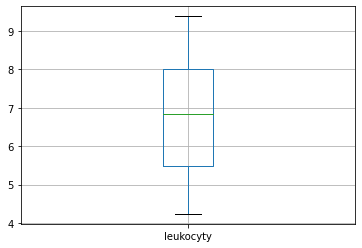

In [53]:
df_labor.boxplot(column=['leukocyty'])

In [54]:
release_outlier_ninja2()

<AxesSubplot:>

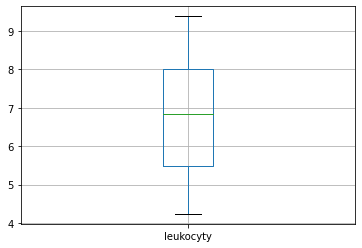

In [55]:
df_labor.boxplot(column=['leukocyty'])

#### Spojenie datasetov  

Spojenie datasetov riešime metódou dataframu **merge** na základe *_ssn_* a *_name_*:

In [56]:
df_merged = df_labor.merge(df_profiles, on=['ssn', 'name'], how='inner')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9734 entries, 0 to 9733
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   hemoglobin        9704 non-null   float64       
 1   leukocyty         9705 non-null   float64       
 2   etytr             9705 non-null   float64       
 3   weight            9734 non-null   float64       
 4   trombocyty        9704 non-null   float64       
 5   ast               9704 non-null   float64       
 6   alp               9704 non-null   float64       
 7   relationship      9734 non-null   category      
 8   name              9734 non-null   object        
 9   alt               9705 non-null   float64       
 10  hbver             9704 non-null   float64       
 11  smoker            9734 non-null   category      
 12  erytrocyty        9704 non-null   float64       
 13  er-cv             9704 non-null   float64       
 14  indicator         9734 n

Na základe **info** je potrebné riešiť transformáciu viacerých údajov na numerické

## 2. Realizácia predspracovania dát 

### Zadanie  
- Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu (train and test dataset) podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím datasetom.
- Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
- Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)
    
### Riešenie



In [29]:
def scalingNinja(df_toScale):   
    min_max_scaler = preprocessing.MinMaxScaler(feature_range =(0, 1))
    scaled_dataframe = min_max_scaler.fit_transform(df_toScale.values.reshape(-1,1))
    return scaled_dataframe

def standardisatingNinja(df_toScale):
    Standardisation = preprocessing.StandardScaler()
    scaled_dataframe = Standardisation.fit_transform(df_toScale.values.reshape(-1,1))
    return scaled_dataframe

def powerTransform(df_toTransform):
    return power_transform(df_toTransform.values.reshape(-1,1))

In [30]:
df_labor["ast"] = scalingNinja(df_labor["ast"])
df_labor["ast"].head()

0    0.618501
1    0.669072
2    0.653309
3    0.673371
4    0.674875
Name: ast, dtype: float64

In [31]:
df_labor["alp"] = standardisatingNinja(df_labor["alp"])
df_labor["alp"].head()

0    0.497458
1    0.983211
2    0.153915
3   -1.925259
4    0.946127
Name: alp, dtype: float64

In [32]:
df_labor["alt"] = powerTransform(df_labor["alt"])
df_labor["alt"].head()

0    0.675003
1   -0.897033
2   -0.938073
3   -0.841692
4   -0.173226
Name: alt, dtype: float64

In [33]:
df_labor.head()

,Unnamed: 0,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,name,alt,hbver,smoker,erytrocyty,er-cv,indicator,ssn,hematokrit
0,0,6.77299,5.28153,4.79087,104.22450,7.22472,0.618501,0.497458,married,Kathryn Wagner,0.675003,9.04461,no,7.94417,61.31451,0.0,887-91-9698,5.40103
1,1,6.35217,5.45245,3.34754,65.03608,7.00407,0.669072,0.983211,widowed,Frank Becker,-0.897033,9.09262,no,5.33302,58.00624,0.0,506-37-0250,7.68167
2,2,5.37162,7.36106,7.10989,63.61518,6.95232,0.653309,0.153915,married,Stephanie Lewis,-0.938073,6.18215,no,6.38771,62.73102,1.0,331-52-1241,6.27422
3,3,4.60987,8.04010,4.97779,30.35294,6.63243,0.673371,-1.925259,married,Luis Williams,-0.841692,5.22920,no,5.05640,62.60592,1.0,407-22-7513,6.61263
4,4,5.97408,6.66899,5.58872,97.97181,6.18242,0.674875,0.946127,divoced,Donald Hall,-0.173226,4.97805,yes,5.10205,59.32470,1.0,486-30-7935,6.23117


## 3. Výber atribútov pre strojové učenie

### Zadanie  
- Zistite ktoré atribúty (features) vo vašich dátach pre strojové učenie sú informatívne k atribútu “indikator”.
- Zoradíte tie atribúty v poradí podľa dôležitosti. 
- Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie) 

### Riešenie




## 4. Replikovateľnosť predspracovania

### Zadanie  
- Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny (napr. pomocou funkcie/í)
- Očakáva sa aj využitie možnosti sklearn.pipeline

### Riešenie  

 - Pre replikovateľnosť kódu znovu načítame dataset, aby sme mohli realizovať jednoltivé časti zadania vo funkciách:  

In [3]:
# read labor and profiles dataset
df_labor_ = pd.read_csv('../../data/labor.csv', sep='\t')
df_profiles_ = pd.read_csv('../../data/profiles.csv', sep='\t')

 - spojenie datasetov cez funkciu: 

In [40]:
# https://stackoverflow.com/questions/48320396/create-a-custom-sklearn-transformermixin-that-transforms-categorical-variables-c
class MergeTransformer(TransformerMixin):
    """
    A tranformer for merging 2 datasets.
    """
    cols = list()
    
    def __init__(self, *args, **kwargs):
        """
        Initialize method.

        :param *args: 2 datasets are instance of pandas.core.frame.DataFrame
        :param **kwargs: dictionary of names of columns
        """
        self.data1 = args[0]
        self.data2 = args[1]
        for col in kwargs.values():
            self.cols.append(col)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to merge 2 datasets in *args with columns in **kwargs.

        :param X: 2 datasets are instance of pandas.core.frame.DataFrame
        :returns: pandas.core.frame.DataFrame
        """
        X = self.data1.merge(self.data2, on=self.cols, how = 'inner')
        return X

 - odstránenie zadaných stĺpcov cez funkciu

In [42]:
class DropColsTransformer(TransformerMixin):
    """
    A tranformer for droping columns from the dataset.
    """
    
    def __init__(self, data, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        """
        self.data = data
        self.cols = list(args)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to delete columns specified in *args to be deleted from data.

        :param X: pandas.core.frame.DataFrame
        :returns: pandas.core.frame.DataFrame without columns specified in *args
        :raises keyError: raises an exception in case column was not found
        """
        try:
            X = X.drop(self.cols, axis=1)
            return X
        except KeyError:
            print(f'Something from {self.cols} not found in dataset!') 

 - numerical transformer

In [43]:
class GetNumericalTransformer(TransformerMixin):
    """
    A tranformer for getting numerical values from the dataset.
    """
    
    def __init__(self, data, col, what, category=None, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param col: col to be transformed
        :param what: dictionary, transform based on this
        :param category: change type based on this
        :param *args: -
        """
        self.data = data
        self.col = col
        self.what = what
        self.category = category
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to transform column to a numeric and change a type.

        :param X: pandas.core.frame.DataFrame
        :returns: transformed pandas.core.frame.DataFrame
        :raises keyError: raises an exception in case column was not found
        """
        try:
            X[self.col].replace(self.what, inplace=True)
            if self.category is not None:
                X = X.astype({self.col: self.category})
            return X
        except KeyError:
            print(f'Something from {self.what} not found in dataset!')  

In [34]:
class PowerTransform(TransformerMixin):
    """
    A tranformer for normalising columns via power transformation.
    """
    
    def __init__(self, data, method, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        """
        self.data = data
        self.cols = list(args)
        #for col in kwargs.values():
        #    self.cols.append(col)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to delete columns specified in *args to be deleted from data.

        :param data: pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        :returns: pandas.core.frame.DataFrame without columns specified in *args
        :raises keyError: raises an exception in case column was not found
        """
        try:
            for col in self.cols:
                 X[col] = powerTransform(X[col])
                 #X[: , col] = power_transform(X[: , col].values.reshape(-1,1))
            return X
        except KeyError:
            print(f'Something from {self.cols} not found in dataset!') 
    

In [44]:
class ScalingTransform(TransformerMixin):
    """
    A tranformer for normalising columns via power transformation.
    """
    
    def __init__(self, data, method, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        """
        self.data = data
        self.cols = list(args)
        self.method = method
        #for col in kwargs.values():
        #    self.cols.append(col)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to delete columns specified in *args to be deleted from data.

        :param data: pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        :returns: pandas.core.frame.DataFrame without columns specified in *args
        :raises keyError: raises an exception in case column was not found
        """
        try:
            if self.method == "Scaling":
                for col in self.cols:
                    X[col] = scalingNinja(X[col])
                     #X[: , col] = power_transform(X[: , col].values.reshape(-1,1))
                return X
            if self.method == "Standard":
                for col in self.cols:
                    X[col] = standardisatingNinja(X[col])
                     #X[: , col] = power_transform(X[: , col].values.reshape(-1,1))
                return X
        except KeyError:
            print(f'Something from {self.cols} not found in dataset!') 
    

In [45]:
class FillingTransform(TransformerMixin):
    """
    A tranformer for normalising columns via power transformation.
    """
    
    def __init__(self, data, method, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        """
        self.data = data
        self.cols = list(args)
        self.method = method
        #for col in kwargs.values():
        #    self.cols.append(col)
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to delete columns specified in *args to be deleted from data.

        :param data: pandas.core.frame.DataFrame
        :param *args: tuple of *str, specifing cols to be dropped
        :returns: pandas.core.frame.DataFrame without columns specified in *args
        :raises keyError: raises an exception in case column was not found
        """
        try:
            if self.method == "mean":
                for col in self.cols:
                    X[col] = X[col].fillna(X[col].mean())
                return X
            if self.method == "median":
                for col in self.cols:
                    X[col] = X[col].fillna(X[col].median())
                return X
            if self.method == "knn":
                for col in self.cols:
                    imputer = KNNImputer(n_neighbors=5)
                    imputer.fit(X[col].values.reshape(-1,1))
                    Xtrans = imputer.transform(X[col].values.reshape(-1,1))
                    X[col] = pd.DataFrame(Xtrans)
                return X
            if self.method == "regression":
                for col in self.cols:
                    X[col] = X[col].interpolate(method='linear')
                return X
            
            
        except KeyError:
            print(f'Something from {self.cols} not found in dataset!') 
    

In [46]:
class RatioFillingTransformer(TransformerMixin):
    """
    A tranformer for getting numerical values from the dataset.
    """
    
    def __init__(self,  data, colToFill, corrCol, *args):
        """
        Initialize method.

        :param data: The dataset is instance of pandas.core.frame.DataFrame
        :param col: col to be transformed
        :param what: dictionary, transform based on this
        :param category: change type based on this
        :param *args: -
        """
        self.data = data
        self.colToFill = colToFill
        self.corrCol = corrCol
        
    def fit(self, X, y=None):
        """
        Fits transformer over data.

        :param X: The dataset to pass to the transformer.
        :returns: The transformer.
        """
        return self
    
    def transform(self, X, **transform_params):
        """
        Function to transform column to a numeric and change a type.

        :param X: pandas.core.frame.DataFrame
        :returns: transformed pandas.core.frame.DataFrame
        :raises keyError: raises an exception in case column was not found
        """
        try:
            ratio = X[self.colToFill]/X[self.corrCol]
            X[self.colToFill] = X[self.colToFill].fillna(X[self.corrCol] * ratio.mean())
            return X
        except KeyError:
            print(f'Something from {self.what} not found in dataset!')  

 - transformácia údajov

In [47]:
df_merged = pd.DataFrame()

# pipeline pre spojenie dát
merge_pipeline = Pipeline(
    [
        ('merge', MergeTransformer(df_labor_, df_profiles_, column1 ='ssn', column2 ='name')),
        ('dropCols', DropColsTransformer(df_merged, 'Unnamed: 0_x', 'name', 'ssn', 'Unnamed: 0_y', 
                                      'current_location', 'residence', 'address')),
        ('numSex', GetNumericalTransformer(df_merged, 'sex', {"M": 0, "F": 1}, 'category')),
        ('numBlood', GetNumericalTransformer(df_merged, 'blood_group', {
                "A+": 1,"A-": 2, "B+": 3, "B-": 4, "AB+": 5, "AB-": 6, "O+": 7, "O-": 8
            }, 'category')
        ),
        ('numRepairRace', GetNumericalTransformer(df_merged, 'race', {
            "blsck": "Black", "black": "Black", "white": "White"})
        ),
        ('numRace', GetNumericalTransformer(df_merged, 'race', {
            "White": 1,"Black": 2, "Asian": 3, "Hawaiian": 4, "Indian": 5}, 'category')
        ),
        ('numSmoker', GetNumericalTransformer(df_merged, 'smoker', {
            "no": 0, "N": 0, "yes": 1, "Y": 1}, 'category')
        ),
        ('Transformer_mean',FillingTransform(df_labor, "mean", "hemoglobin", "trombocyty")),
        ('Transformer_median',FillingTransform(df_labor,"median", "er-cv", "hematokrit")),
        ('Transformer_knn',FillingTransform(df_labor,"knn", "ast", "alp")),
        ('Transformer_regression',FillingTransform(df_labor,"regression", "etytr", "alt")),
        ('Transformer_ratio',RatioFillingTransformer(df_labor, "leukocyty","etytr")),
        ('Transformer_ratio2',RatioFillingTransformer(df_labor, "erytrocyty","alt")),
        ('Transformer_ratio3',RatioFillingTransformer(df_labor, "hbver","erytrocyty")),
        ('Transformer_yeo', PowerTransform(df_labor, 'yeo-johnson', 'alt')),
        ('Transformer_scal', ScalingTransform(df_labor, "Scaling", 'ast')),
        ('Transformer_stand', ScalingTransform(df_labor, "Standard", 'alp'))
    ]
)

df_merged = merge_pipeline.transform(df_merged)
df_merged


NameError: name 'df_labor_' is not defined

In [ ]:
df_labor.isna().sum()